#### classifying CIFAR10 with CNN 
#### with linear model accuracy didn't go above 44%

In [1]:
#import everything
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

In [56]:
dataset = CIFAR10(root='datasets/',download=True,transform=ToTensor())

Files already downloaded and verified


In [57]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [58]:
dataset[0][0].shape

torch.Size([3, 32, 32])

In [59]:
dataset.classes[train_dataset[0][1]]

'frog'

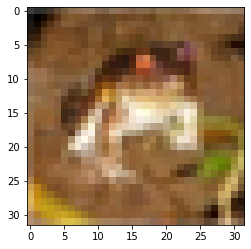

In [60]:
plt.imshow(dataset[0][0].permute(1,2,0))

In [7]:
#so that barely looks like a frog
random_seed=43
torch.manual_seed(random_seed)

In [61]:
len(dataset)

50000

In [62]:
train_dataset,valid_dataset = random_split(dataset,[45000,5000])

In [10]:
test_dataset = CIFAR10(root='datasets/',train=False,transform=ToTensor())

In [11]:
len(test_dataset)

10000

In [12]:
#for GPU optims
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [13]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [14]:
class DeviceDataLoader(): #wrapper over DataLoader class, to push it to device and create __iter__ class for taking full advantage of GPU
    def __init__(self,data_loader,device):
        self.data_loader = data_loader
        self.device = device
    
    def __iter__(self): #this class makes the magic of GPU happen
        for batch in self.data_loader:
            yield(to_device(batch,self.device))
    
    def __len__(self):
        return len(self.data_loader)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
#create loaders
batch_size=128
train_loader = DeviceDataLoader(DataLoader(train_dataset,batch_size,shuffle=True,pin_memory=True,num_workers=4),device)
valid_loader = DeviceDataLoader(DataLoader(valid_dataset,batch_size*2,pin_memory=True,num_workers=4),device)
test_loader  = DeviceDataLoader(DataLoader(test_dataset,batch_size*2,pin_memory=True,num_workers=4),device)

In [17]:
class ImageBase(nn.Module):
    def train_step(self,X_batch):
        images,labels = X_batch
        out = self.forward(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def valid_step(self,X_batch):
        images,labels = X_batch
        out = self.forward(images)
        loss = F.cross_entropy(out,labels)
        _,preds = torch.max(out,dim=1)
        acc = torch.tensor(torch.sum(preds==labels).item()/len(preds))
        return {'loss':loss,'acc':acc}

In [18]:
class CIFAR10Model(ImageBase):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.ReLU(), #3 to 32 channel first
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(), #32 to 64 channel, till now size is still 32x32 of image, even though channels have increased
            nn.MaxPool2d(2,2), # size reduced to 16x16
            
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(), #64 to 128
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # size reduced to 8x8
            
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(), #3 to 32 channel first
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(), #32 to 64 channel, till now size is still 32x32 of image, even though channels have increased
            nn.MaxPool2d(2,2), # size reduced to 4x4
            
            nn.Flatten(),
            nn.Linear(256*4*4,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    def forward(self,X_batch):
        return self.net(X_batch)

In [25]:
model = CIFAR10Model()
model
to_device(model,device)

CIFAR10Model(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

In [26]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0173,  0.0004,  0.0149,  0.0369,  0.0319,  0.0140,  0.0062,  0.0222,
        -0.0055,  0.0178], device='cuda:0', grad_fn=<SelectBackward>)


In [27]:
def evaluate(model,loader):
    out = [model.valid_step(batch) for batch in loader]
    batch_loss = [x['loss'] for x in out]
    batch_acc  = [x['acc'] for x in out]
    epoch_loss = torch.stack(batch_loss).mean()
    epoch_acc  = torch.stack(batch_acc).mean()
    print(f"loss is {epoch_loss} and acc is {epoch_acc}")

In [28]:
def train(model,train_loader,valid_loader,num_epochs=10,lr=0.01,optim_func=torch.optim.SGD):
    optim = optim_func(model.parameters(),lr)
    for epoch in range(num_epochs):
        for batch in train_loader:
            loss = model.train_step(batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
        evaluate(model,valid_loader)

In [29]:
evaluate(model,valid_loader)

loss is 2.302569627761841 and acc is 0.1067095547914505


In [30]:
train(model,train_loader,valid_loader,5,0.001,torch.optim.Adam)

loss is 1.497259497642517 and acc is 0.45211395621299744
loss is 1.2265287637710571 and acc is 0.5576746463775635
loss is 1.0043538808822632 and acc is 0.6428998112678528
loss is 0.8604998588562012 and acc is 0.6948643922805786
loss is 0.7595627903938293 and acc is 0.7329388856887817


In [31]:
train(model,train_loader,valid_loader,5,0.0001,torch.optim.Adam)

loss is 0.7074953317642212 and acc is 0.7591682076454163
loss is 0.7069641947746277 and acc is 0.763051450252533
loss is 0.7104300260543823 and acc is 0.759604811668396
loss is 0.7101128101348877 and acc is 0.761017918586731
loss is 0.7262405753135681 and acc is 0.7569622993469238


In [32]:
train(model,train_loader,valid_loader,3,0.00001,torch.optim.Adam)

loss is 0.7263638377189636 and acc is 0.7604089975357056
loss is 0.7312187552452087 and acc is 0.7609260082244873
loss is 0.7328195571899414 and acc is 0.7636833786964417


In [34]:
evaluate(model,valid_loader)

loss is 0.7328195571899414 and acc is 0.7636833786964417


In [35]:
train(model,train_loader,valid_loader,3,0.00001,torch.optim.Adam)

loss is 0.7351624369621277 and acc is 0.7634420990943909
loss is 0.7372557520866394 and acc is 0.7628791332244873
loss is 0.7398781180381775 and acc is 0.7634650468826294


In [64]:
#that's it, we cannot go above 76.36% accuracy with this model
image,label = test_dataset[0]

In [65]:
image.shape

torch.Size([3, 32, 32])

In [66]:
image = image.unsqueeze(0)

In [67]:
image.shape

torch.Size([1, 3, 32, 32])

In [68]:
image = to_device(image,device)

In [69]:
pred = model(image)

In [70]:
_,pred_label = torch.max(pred,dim=1)

In [71]:
pred_label[0].item()

3

In [72]:
dataset.classes[pred_label[0].item()]

'cat'

Actual:cat, Predicted:cat


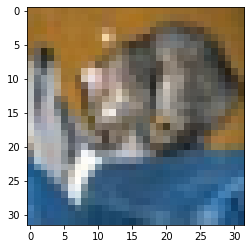

In [73]:
image,label = test_dataset[0]
plt.imshow(image.permute(1,2,0))
print(f"Actual:{dataset.classes[label]}, Predicted:{dataset.classes[pred_label[0].item()]}")